# Non linear phase inversion with minopyApp #

[MiNoPy](https://github.com/geodesymiami/MiNoPy/tree/AugModifications) is an open source python package of InSAR processing with Non Linear phase inversion in full resolution. It reads a stack of coregistered SLCs and produces time series of surface deformation by jointly inverting for persistent and distributed scatterers (PS and DS). This Package works with [MintPy](https://github.com/insarlab/MintPy) and different correction steps after phase inversion are perfomed with MintPy. 
In this notebook, we describe different steps and available options in MiNoPy python package.

Details about the algorithms can be found at:
+ S. Mirzaee, F. Amelung, H. Fattahi, Non-linear phase inversion using joined distributed And Persistent Scatterers. (in prep)


# general overview #

The time series analysis workflow in minopyApp consists of 8 steps which will be explained one by one through an example dataset.

###  Example data:
The example data we use here is a stack of Sentinel-1 images in descending track 142 acquired over Guagua Pichincha volcano, Ecuador ([Zenodo](https://zenodo.org/record/5167298/files/PichinchaSenDT142.zip); ~318M in size). It spans from 2016.04.19 to 2017.12.28 with 46 acquisitions in total. We use the stack Sentinel processor ([Fattahi et al., 2016](https://ieeexplore.ieee.org/document/7637021)) within ISCE ([Rosen et al., 2012](https://ieeexplore.ieee.org/document/6217174/authors#authors)) for coregistering the SAR stack.

## 0. Initial setup of the notebook ##

The cell below performs the intial setup of the notebook and **must be run every time the notebook (re)starts**. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [35]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mintpy.objects import ifgramStack
from mintpy.utils import plot as pp, utils as ut
from mintpy import view, plot_network

# define work directory
work_dir = os.path.expanduser('~/data/test')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download example dataset
url = 'https://zenodo.org/record/5214439/files/PichinchaSenDT142.zip'
zip_file = os.path.basename(url)
proj_name = zip_file.split('.')[0]
if not os.path.isfile(zip_file):
    !wget {url}
else:
    print('{} exists, skip re-download.'.format(zip_file))

# uncompress example dataset
if not os.path.isdir(proj_name):
    print('uncompressing the zip file ...')
    !unzip -q {zip_file}

# go to project directory
proj_dir = os.path.join(work_dir, proj_name)
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

Go to work directory: /Users/Sara/data/test
PichinchaSenDT142.zip exists, skip re-download.
Go to project directory: /Users/Sara/data/test/PichinchaSenDT142


## 1. Setting up template file ##

The configuration parameters to minopyApp.py are controlled through three template files. At least one template is required to run minopyApp.py.    

+ `default template`: [minopyApp.cfg](https://github.com/geodesymiami/MiNoPy/blob/AugModifications/minopy/defaults/minopyApp.cfg). It contains all MiNoPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [minopyApp_auto.cfg](https://github.com/geodesymiami/MiNoPy/blob/AugModifications/minopy/defaults/minopyApp_auto.cfg)). This file is copied over to the current working directory and read every time minopyApp.py runs.


+ `default template`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). It contains all MintPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.


+ `custom template` (optional but recommended): PichinchaSenDT142.template in the example dataset. It contains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the two default templates; if custom template is input, minopyApp.py will update the default minopyApp.cfg and smallbaselineApp.cfg files accordingly.  

### Custom template example ###

The path of all input files (`minopy.load.*`), subset area (`minopy.subset.*`) and the reference point (`mintpy.reference.*`) are always recommended. Below are from PichinchaSenDT142.template file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_slc.py -H to check more details and example inputs.

minopy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isceTops
minopy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
minopy.load.compression    = auto  #[gzip / lzf / no], auto for no.
minopy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:        
minopy.load.slcFile        = ../merged/SLC/*/*.slc.full  #[path2slc_file]
##---------for ISCE only:
minopy.load.metaFile       = ../reference/IW*.xml
minopy.load.baselineDir    = ../baselines
##---------geometry datasets:
minopy.load.demFile          = ../merged/geom_reference/hgt.rdr.full
minopy.load.lookupYFile      = ../merged/geom_reference/lat.rdr.full
minopy.load.lookupXFile      = ../merged/geom_reference/lon.rdr.full
minopy.load.incAngleFile     = ../merged/geom_reference/los.rdr.full
minopy.load.azAngleFile      = ../merged/geom_reference/los.rdr.full
minopy.load.shadowMaskFile   = ../merged/geom_reference/shadowMask.rdr.full
minopy.load.waterMaskFile    = None
##---------interferogram datasets:
minopy.load.unwFile        = ./inverted/interferograms_single_reference/*/*fine*.unw
minopy.load.corFile        = ./inverted/interferograms_single_reference/*/*fine*.cor
minopy.load.connCompFile   = ./inverted/interferograms_single_reference/*/*.unw.conncomp
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
minopy.subset.lalo         = -0.199:-0.142,-78.612:-78.578
# Reference point
mintpy.reference.lalo     = -0.1792, -78.5905

```
    
Run **load_slc.py -H** for example input file paths for ISCE, GAMMA and ROI_PAC.  

There are two sets of options for **MiNoPy (minopyApp.cfg)** starting with `minopy.*` and for **MintPy (smallbaselineApp.cfg)** starting with `mintpy.*`

Run **minopyApp.py -H** for a complete list of options you can use and add to your custom template file.


### Using Docker/Singularity ###

There is `minopy.textCmd` options at the beginning of default `minopyApp.cfg` template file which you may want to set them if you need to run a specific command before everything. For example if you use docker, you need to run commands like this:
```
docker run {your command}
docker run minopyApp.py -h
```
Then you should set:
```
minopy.textCmd   =  docker run
```
### Parallel processing ###

If you want to run tasks in parallel, then you can set the number of workers/cores per node with `minopy.compute.numWorker` option. The default is set to 4 for a personal computer with 4 CPUs.

## 2. minopyApp.py processing steps ##

The minopyApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. 
If you work on HPC, you can create jobs for each step and run them one by one.
More detailed usage can be found in help. 

In [2]:
!minopyApp.py --help

usage: minopyApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--walltime WALL_TIME] [--queue QUEUE] [--start STEP] [--end STEP] [--dostep STEP] [--jobfiles] [--runfiles] [customTemplateFile]

Routine Time Series Analysis for MiNoPy

positional arguments:
  customTemplateFile    Custom template with option settings.
                        ignored if the default minopyApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        Work directory, (default: ./).
  -g                    Generate default template (if it does not exist) and exit.
  -H                    Print the default template file and exit.
  -v, --version         Print software version and exit
  --walltime WALL_TIME  walltime for submitting the script as a job
  --queue QUEUE         Queue name

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
          ['

### 2.1. Create processing steps run files ###

Running `minopyApp.py` with `--runfiles` will create all steps as separate runfiles and you can then run them one by one.

```
minopyApp.py PichinchaSenDT142.template --runfiles --dir ./minopy
```

#### Creating jobs on HPC ####
If you are on HPC, you can create jobs for each run file. If [MinSAR](https://github.com/geodesymiami/rsmas_insar) is installed, you may create jobs automatically by running following command and then submit them in order

```
minopyApp.py PichinchaSenDT142.template --jobfiles --dir ./minopy
```

*We will not run it here since we are not on HPC for this tutorial*


In [4]:
!minopyApp.py PichinchaSenDT142.template --runfiles --dir ./minopy

--------------------------------------------------

_________________________________________________      


  /##      /## /## /##     ##           /#######
 | ###    /###|__/| ###    ##          | ##__  ##    
 | ####  /#### /##| ####   ## / ###### | ##  \ ## /##   /##    
 | ## ##/## ##| ##| ## ##  ##| ##__  ##| #######/| ##  | ##     
 | ##  ###| ##| ##| ## \ ####| ##__  ##| ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  \ ###| ##__  ##| ##      | ##  | ##
 | ## \/  | ##| ##| ##   \ ##|  ###### | ##      |  #######
 |__/     |__/|__/|__/    \__/ \______/|__/       \____  ## 
                                                  /##  | ##
                                                 |  ######/
 Miami Non-Linear Inversion software in Python    \______/ 
          MiNoPy V0.1.0-alpha, 2021-09-14
_________________________________________________

--RUN-at-2021-09-14 13:47:53.087947--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on st

In [5]:
!ls -l minopy/run_files

total 136
-rw-rw-r--  1 Sara  staff    158 Sep 14 13:47 run_01_minopy_load_slc
-rw-rw-r--  1 Sara  staff   1216 Sep 14 13:47 run_02_minopy_phase_inversion
-rw-rw-r--  1 Sara  staff  15263 Sep 14 13:47 run_03_minopy_generate_ifgram
-rw-rw-r--  1 Sara  staff  26811 Sep 14 13:47 run_04_minopy_unwrap_ifgram
-rw-rw-r--  1 Sara  staff    260 Sep 14 13:47 run_05_minopy_load_ifgram
-rw-rw-r--  1 Sara  staff    193 Sep 14 13:47 run_06_mintpy_correct_unwrap_error
-rw-rw-r--  1 Sara  staff     92 Sep 14 13:47 run_07_minopy_phase_to_range
-rw-rw-r--  1 Sara  staff    161 Sep 14 13:47 run_08_mintpy_corrections


### 2.2 Load SLC and geometry stack ###

This step prepares the required metadata (using prep_isce.py) and load all data files and their metadata into HDF5 files in the **./inputs** folder, including:

```cfg
./inputs/slcStack.h5
./inputs/geometryRadar.h5  #for dataset in radar coordinates
./inputs/geometryGeo.h5    #for dataset in geo coordinates or GAMMA dataset, which has lookup table in geo-coordinates
```

The corresponding template options are:

```cfg
########## 3. load SLCs given the area of interest
## auto - automatic path pattern for Univ of Miami file structure
## crop_image.py -h to check more details and example inputs.
## directories are to read from and the subsets will be saved under minopy directory
## compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]

minopy.load.processor      = auto  #[isce,snap,gamma,roipac], auto for isceTops
minopy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
minopy.load.compression    = auto  #[gzip / lzf / no], auto for no.
minopy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:
minopy.load.slcFile        = auto  #[path2slc_file]
##---------for ISCE only:
minopy.load.metaFile       = auto  #[path2metadata_file], i.e.: ./reference/IW1.xml, ./referenceShelve/data.dat
minopy.load.baselineDir    = auto  #[path2baseline_dir], i.e.: ./baselines
##---------geometry datasets:
minopy.load.demFile        = auto  #[path2hgt_file]
minopy.load.lookupYFile    = auto  #[path2lat_file], not required for geocoded data
minopy.load.lookupXFile    = auto  #[path2lon_file], not required for geocoded data
minopy.load.incAngleFile   = auto  #[path2los_file], optional
minopy.load.azAngleFile    = auto  #[path2los_file], optional
minopy.load.shadowMaskFile = auto  #[path2shadow_file], optional
minopy.load.waterMaskFile  = auto  #[path2water_mask_file], optional
minopy.load.bperpFile      = auto  #[path2bperp_file], optional

##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
minopy.subset.yx           = auto    #[y0:y1,x0:x1 / no], auto for no
minopy.subset.lalo         = auto    #[S:N,W:E / no], auto for no
```

You can either run:
```
minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy
```
or run the commands in `run_01_minopy_load_slc`


In [6]:
!minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 13:48:21.437023--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_slc']
Remaining steps: ['phase_inversion', 'generate_ifgram', 'unwrap_ifgram', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:134821 * minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   dir

In [7]:
!ls -l minopy/inputs

total 718832
-rw-r--r--   1 Sara  staff       1889 Aug 17 22:14 PichinchaSenDT142.template
drwxr-xr-x  53 Sara  staff       1696 Jul 19 16:12 baselines
-rw-rw-r--   1 Sara  staff        413 Sep 14 13:48 date_list.txt
-rw-rw-r--   1 Sara  staff   12206017 Sep 14 13:48 geometryRadar.h5
-rw-rw-r--   1 Sara  staff       5890 Sep 14 13:47 minopyApp.cfg
drwxr-xr-x   4 Sara  staff        128 Aug  6 09:26 reference
-rw-rw-r--   1 Sara  staff  354537608 Sep 14 13:48 slcStack.h5
-rw-rw-r--   1 Sara  staff      21152 Sep 14 13:47 smallbaselineApp.cfg


In [8]:
!info.py minopy/inputs/slcStack.h5

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/slcStack.h5
file type: timeseries
coordinates : RADAR

******************** Date Stat Info *************************
Start Date: 20160419
End   Date: 20171228
Number of dates  : 46
STD of datetimes : 0.51 years

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                    1
  ANTENNA_SIDE              -1
  AZIMUTH_PIXEL_SIZE        15.61631188914008
  CENTER_INCIDENCE_ANGLE    46.153805
  CENTER_LINE_UTC           39141.0
  DATA_TYPE                 complex64
  DATE                      20161209
  EARTH_RADIUS              6337298.410627297
  FILE_LENGTH               530
  FILE_PATH                 /Users/Sara/data/test/PichinchaSenDT142/merged/SLC/20161209/20161209.slc.full
  FILE_TYPE                 timeseries
  HEADING                   -167.96890986886464
  HEIGHT                    698882.4836057822
  I

In [9]:
!info.py ./minopy/inputs/geometryRadar.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                    1
  ANTENNA_SIDE              -1
  AZIMUTH_PIXEL_SIZE        15.61631188914008
  CENTER_INCIDENCE_ANGLE    46.153805
  CENTER_LINE_UTC           39141.0
  DATA_TYPE                 complex64
  DATE                      20161209
  EARTH_RADIUS              6337298.410627297
  FILE_LENGTH               530
  FILE_PATH                 /Users/Sara/data/test/PichinchaSenDT142/merged/SLC/20161209/20161209.slc.full
  FILE_TYPE                 geometry
  HEADING                   -167.96890986886464
  HEIGHT                    698882.4836057822
  ISCE_VERSION              Release: 2.5.1, svn-, 20210305. Current: svn-.
  LAT_REF1                  -0.14213333
  LAT_REF2                  -0.13301475
  LA

run view.py in MintPy release version v1.3.1-12, release date 2021-08-19
input file is geometry file: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/geometryRadar.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file geometryRadar.h5: 7
datasets to exclude (0):
[]
datasets to display (7):
['height', 'latitude', 'longitude', 'incidenceAngle', 'azimuthAngle', 'slantRangeDistance', 'shadowMask']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: geometryRadar
figure size : [15.00, 8.00]
dataset number: 7
row     number: 4
column  number: 2
figure  number: 1
----------------------------------------
Figure 1 - geometryRadar.png
reading data as a list of 2D matrices ...
[==================================================] shadowMask

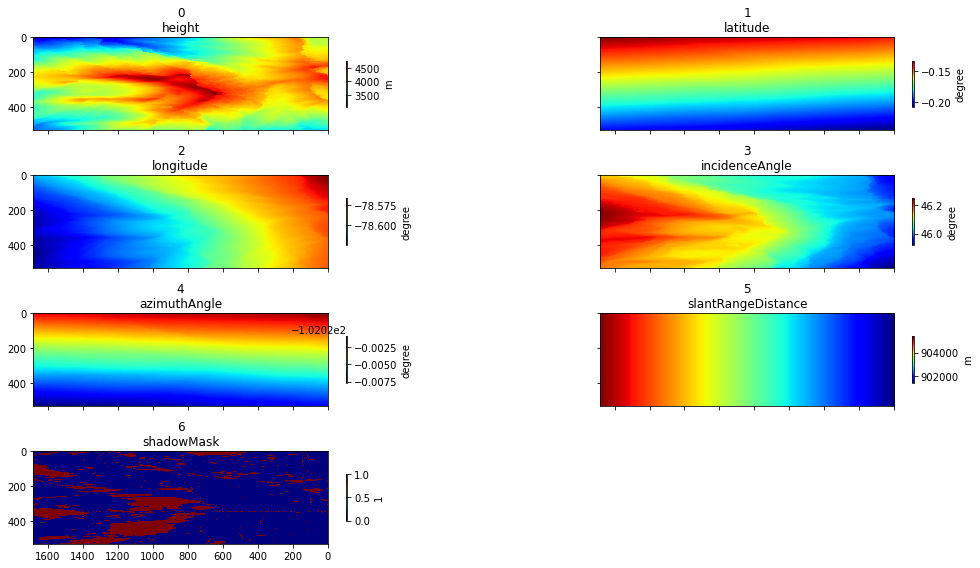

In [10]:
view.main('./minopy/inputs/geometryRadar.h5'.split())

### 2.2 Phase inversion ###

This step runs the phase linking using wrapped phase series. following are the options used for this step. Phase linking methods supported by MiNoPy are **EVD** ([Fornaro et al., 2015](https://ieeexplore.ieee.org/document/6912985), **EMI** ([Ansari et al., 2018](https://ieeexplore.ieee.org/document/8365087)) and **PTA** ([Ferretti et al., 2011](https://ieeexplore.ieee.org/abstract/document/5765671)). All of them can be run in sequential mode **(sequential_EVD, sequential_EMI and sequential_PTA)** ([Ansari et al., 2017](https://ieeexplore.ieee.org/document/8024151)). 
MiNoPy also supports **StBAS** [Ansari et al., 2017] and you can choose a bandwidth (lag time) by setting `minopy.inversion.stbas_time_lag ` option in template.

For sequential mode, you can set the number of images as ministack size by `minopy.inversion.ministackSize`. Range and azimuth window are the size of searching window to find statistical homogeneous pixels (SHPs). Shp test is the statistical test to find SHPs and three tests are supported by MiNoPy including **KS** ([Stephens, 1970](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1970.tb00821.x)), **AD** ([Scholz & Stephens, 1987](https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478517)) and **ttest** ([Derrick et al., 2017](https://www.tqmp.org/RegularArticles/vol13-2/p120/)).

This step supports parallel processing by dividing the subset area into patches of size `n by n`, for example the default size is 200 and the data will be divided into patches of size `200 by 200`. You can set the number of parallel jobs (no more than available CPUs) using `minopy.compute.numWorker` and the patch size by `minopy.inversion.patchSize `. 

Depending on the number of parallel jobs, number of images, the processing method and the subset area (number of patches), the processing time varies. For one patch of `200*200` pixels and 46 images, processing time is 400 seconds (6 min) with a 2.8 GHz processor. 


```cfg
########## 2. parallel job setting
minopy.compute.numWorker              = auto    # auto for 4

########## 4. Divide the area into patches and do phase inversion
## window sizes are used in step 2, 3,
minopy.inversion.patchSize                = auto   # patch size (n*n) to divide the image for parallel processing, auto for 200
minopy.inversion.ministackSize            = auto   # number of images in each ministack, auto for 10
minopy.inversion.rangeWindow              = auto   # range window size for searching SHPs, auto for 19
minopy.inversion.azimuthWindow            = auto   # azimuth window size for searching SHPs, auto for 7
minopy.inversion.shpTest                  = auto   # [ks, ad, ttest] auto for ks: kolmogorov-smirnov test
minopy.inversion.phaseLinkingMethod       = auto   # [EVD, EMI, PTA, sequential_EVD, sequential_EMI, sequential_PTA, StBAS], auto for sequential_EMI
minopy.inversion.stbas_time_lag           = auto   # auto for 10

```


Either run:
```
minopyApp.py PichinchaSenDT142.template --dostep phase_inversion --dir ./minopy
```
or run the commands in run_02_minopy_inversion


In [11]:
!minopyApp.py PichinchaSenDT142.template --dostep phase_inversion --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 13:56:59.746392--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['phase_inversion']
Remaining steps: ['generate_ifgram', 'unwrap_ifgram', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:135659 * minopyApp.py PichinchaSenDT142.template --dostep phase_inversion --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   director

[==================================================] 26000/26000 pixels, patch 25    Phase invertion of PATCH_25 is Completed in 73.162926197052 s

Unpatch and write wrapped phase time series to HDF5 file phase_series.h5 
open  HDF5 file phase_series.h5 in a mode
--------------------------------------------------
unpatch block 0/27 : [  0   0 200 200]
--------------------------------------------------
unpatch block 1/27 : [200   0 400 200]
--------------------------------------------------
unpatch block 2/27 : [400   0 600 200]
--------------------------------------------------
unpatch block 3/27 : [600   0 800 200]
--------------------------------------------------
unpatch block 4/27 : [ 800    0 1000  200]
--------------------------------------------------
unpatch block 5/27 : [1000    0 1200  200]
--------------------------------------------------
unpatch block 6/27 : [1200    0 1400  200]
--------------------------------------------------
unpatch block 7/27 : [1400    0 1600  200]


So far we have inverted the wrapped phase series with sequential_EMI phase linking method and we have the single reference interferograms saved in HDF5 format. The interferograms then need to be unwrapped and converted to displacement time series.

view.py ./minopy/inverted/quality -c gray --notick --noaxis --noverbose


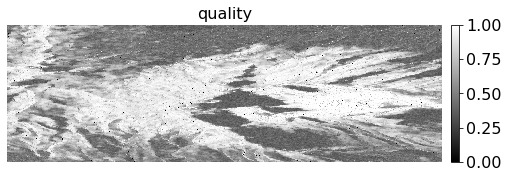

view.py ./minopy/shp --notick --noaxis --noverbose


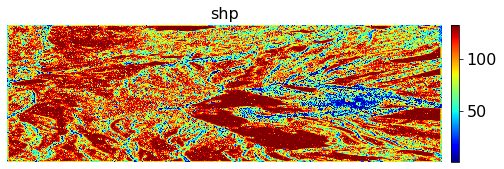

view.py ./minopy/maskPS.h5 --notick --noaxis --noverbose


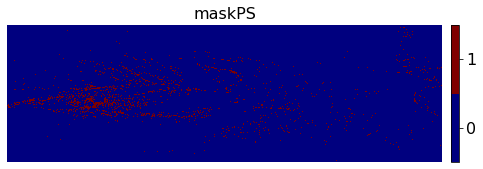

In [12]:
view.main('./minopy/inverted/quality -c gray --notick --noaxis --noverbose'.split())
view.main('./minopy/shp --notick --noaxis --noverbose'.split())
view.main('./minopy/maskPS.h5 --notick --noaxis --noverbose'.split())

A by product of inversion is PS mask `maskPS.h5` for those who are interested in PS pixels only specially in urban areas.

run view.py in MintPy release version v1.3.1-12, release date 2021-08-19
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5 in float32 format
file size in y/x: (530, 1685)
input dataset: "['phase']"
num of datasets in file phase_series.h5: 94
datasets to exclude (0):
[]
datasets to display (46):
['phase-1', 'phase-2', 'phase-3', 'phase-4', 'phase-5', 'phase-6', 'phase-7', 'phase-8', 'phase-9', 'phase-10', 'phase-11', 'phase-12', 'phase-13', 'phase-14', 'phase-15', 'phase-16', 'phase-17', 'phase-18', 'phase-19', 'phase-20', 'phase-21', 'phase-22', 'phase-23', 'phase-24', 'phase-25', 'phase-26', 'phase-27', 'phase-28', 'phase-29', 'phase-30', 'phase-31', 'phase-32', 'phase-33', 'phase-34', 'phase-35', 'phase-36', 'phase-37', 'phase-38', 'phase-39', 'phase-40', 'phase-41', 'phase-42', 'phase-43', 'phase-44', 'phase-45', 'phase-46']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/

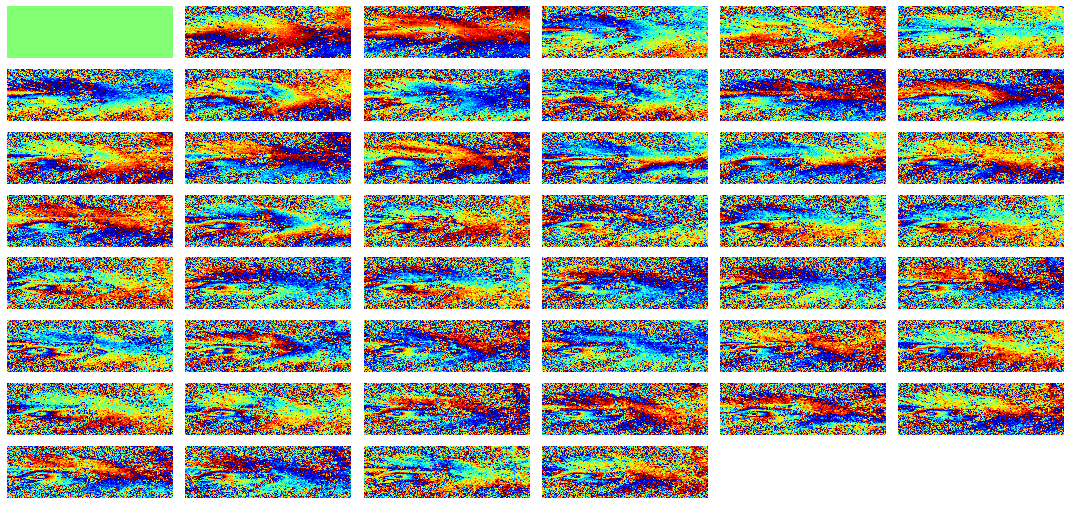

In [13]:
view.main('./minopy/inverted/phase_series.h5 phase --noaxis --nowhitespace'.split())

### 2.3 Select pairs to unwrap ###

Unwrapping is a tedius and difficult task. Since you are working in full resolution and for long temporal baselines, you may have low spatial coherence. So in MiNoPy, you can select a network of minimum interferograms to unwrap and then convert phase to range changes.

For that, there are three options for which pairs to unwrap (following options in template). We use the single reference pairs for this example.
The filter strength has been set to 0 by default but you may do additional filtering at this step.

```cfg
########## 5. Select the interferograms to unwrap
## Different pairs of interferograms can be choosed for unwrapping.
## Following is a short description of each type and the MintPy unwrapping error correction that is valid for them
## 1. mini_stacks: It unwraps single reference interferograms in each ministack. Only bridging for unwrap error correction
## 2. single_reference: It unwraps the single reference interferograms of the whole stack using referenceDate. Only bridging for unwrap error correction
## 3. delaunay: delaunay triangles with temporal and spatial baseline threshold. Both bridging and phase_closure can be used.
## 4. sequential: sequential interferograms, Not recommended for phase analysis. Bridging can be used.
## You may also unwrap certain combination of pairs by giving them in a text file as minopy.interferograms.list
minopy.interferograms.type               = auto     # [mini_stacks, single_reference, delaunay, sequential] default: single_reference
minopy.interferograms.list               = auto     # auto for None, list of interferograms to unwrap in a text file
minopy.interferograms.referenceDate      = auto     # auto for the middle image
minopy.interferograms.filterStrength     = auto     # [0-1], interferogram smoothing factor, auto for 0
minopy.interferograms.ministackSize      = auto     # number of images in each ministack (if mini_stacks is used), auto for 10
minopy.interferograms.delaunayTempThresh = auto     # [days] temporal threshold for delaunay triangles, auto for 60
minopy.interferograms.delaunayPerpThresh = auto     # [meters] Perp baseline threshold for delaunay triangles, auto for 200
```

**The network for single reference pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_single_reference.png">
</p>     

**Mini stack pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_mini_stacks.png">
</p>     


**Delaunay triangle pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_delaunay.png">
</p>     

**sequential pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_sequential.png">
</p> 

In [14]:
!minopyApp.py PichinchaSenDT142.template --dostep generate_ifgram --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 14:33:19.369769--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['generate_ifgram']
Remaining steps: ['unwrap_ifgram', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:143319 * minopyApp.py PichinchaSenDT142.template --dostep generate_ifgram --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy 

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160525/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160513/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160630/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160525/filt_fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/mino


 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines

API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160817/filt_fine.int
array width, height, offset:  1685   530     0
line:    64API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160829/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160910/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161016/fine.int
line:   128API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160922/fine.int
line:   160GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160829/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160829/filt_fine.int
array wi


 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimu

API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161209/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170102/fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/filt_fine.int
array width, height, offset:  1685   530     0
line:     0API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170315/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170219/fine.int
API close:  /Users/Sara/data/test/Pich

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/filt_fine.int.vrt

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.cor
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/filt_fine.cor

 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines: 

API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170514/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170502/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170701/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170607/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_sing

line:   491
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:   496
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
line:   497 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:   503
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches

20210914:143343 * generate_ifgram.py --reference 20170408 --secondary 20171017 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171017 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5
20210914:143343 * generate_ifgram.py --reference 20170408 --secondary 20170830 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5
20210914:143343 * generate_ifgram.py --reference 20170408 --secondary 20170911 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170911 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data

line:   436GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.int.vrt
line:   443GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.int.vrt
line:   453API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.cor
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.cor
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170923/filt_fine.int.vrt
line:   461
 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0
line:   462
 << PS filtering >>


 interferogram width:  

20210914:143348 * generate_ifgram.py --reference 20170408 --secondary 20171110 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171110 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5
20210914:143348 * generate_ifgram.py --reference 20170408 --secondary 20171228 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171228 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5
20210914:143348 * generate_ifgram.py --reference 20170408 --secondary 20171122 --output_dir /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data


 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH

In [15]:
!ls -l ./minopy/inverted

total 745592
drwxrwxr-x  29 Sara  staff        928 Sep 14 14:18 PATCHES
drwxrwxr-x  47 Sara  staff       1504 Sep 14 13:47 interferograms_single_reference
-rw-rw-r--   1 Sara  staff     893050 Sep 14 14:33 mask_unwrap
-rw-rw-r--   1 Sara  staff       3150 Sep 14 14:33 mask_unwrap.rsc
-rw-rw-r--   1 Sara  staff  360356648 Sep 14 14:19 phase_series.h5
-rw-rw-r--   1 Sara  staff    3572200 Sep 14 14:19 quality
-rw-rw-r--   1 Sara  staff        375 Sep 14 14:19 quality.vrt
-rw-rw-r--   1 Sara  staff       3830 Sep 14 14:19 quality.xml
-rw-rw-r--   1 Sara  staff    3572200 Sep 14 14:33 quality_msk
-rw-rw-r--   1 Sara  staff        749 Sep 14 14:33 quality_msk.rsc


### 2.4 Unwrap interferograms ###

For this step you may use your own unwrapping software. MiNoPy uses [SNAPHU](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/) and you can set the following parameters for unwrapping. If you have a mask in HDF5 format like `waterMask.h5`, you can use it by `minopy.unwrap.mask`

```cfg
########## 6. Unwrap parameters
minopy.unwrap.maxDiscontinuity           = auto     # (snaphu parameter) max phase discontinuity in cycle, auto for 1.2
minopy.unwrap.initMethod                 = auto     # [MCF, MST] auto for MCF
minopy.unwrap.mask                       = auto     # auto for None
```

Furthermore, if you want to set mote [parameters](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/snaphu.conf.full) from snaphu, you can add them in `conf.full` in your minopy directory (PichinchaSenDT142/minopy/conf.full). MiNoPy will unwrap in tile mode if your subset area is large. Following you will find the parameters set by default:


In [16]:
!cat ./minopy/conf.full

INITMETHOD	MCF
INFILEFORMAT   COMPLEX_DATA
OUTFILEFORMAT	ALT_LINE_DATA
CORRFILEFORMAT	FLOAT_DATA
MINCONNCOMPFRAC 	0.01
SINGLETILEREOPTIMIZE   FALSE
STATCOSTMODE  DEFO
RMTMPTILE 	   TRUE
MAXNCOMPS       100
CONNCOMPTHRESH  300


In [17]:
!minopyApp.py PichinchaSenDT142.template --dostep unwrap_ifgram --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 14:35:16.061221--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['unwrap_ifgram']
Remaining steps: ['load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:143516 * minopyApp.py PichinchaSenDT142.template --dostep unwrap_ifgram --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg 

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160805/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160805/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160805/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160805/filt_fine.unw.conncomp.vrt
Time spent: 1.4146665016810098 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_2016

2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161022/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161022/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161022/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161109/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161109/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161109/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161016/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161016/fi

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.unw.conncomp.vrt
Time spent: 1.200194231669108 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170

2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170713/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170713/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170713/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/fi

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.unw.conncomp.vrt
Time spent: 1.4135621150334676 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_2017

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/filt_fine.unw.conncomp.vrt
Time spent: 0.8500769337018331 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171110/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171110/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_2017

### 2.5 Load interferograms in a stack (MintPy format) ###

In this step you will load unwrapped interferograms to `./minopy/inputs/ifgramStack.h5`, MintPy format.
The available options are:
```cfg
##---------interferogram datasets:
minopy.load.unwFile        = auto  #[path2unw_file]
minopy.load.corFile        = auto  #[path2cor_file]
minopy.load.connCompFile   = auto  #[path2conn_file], optional
minopy.load.intFile        = auto  #[path2int_file], optional
minopy.load.ionoFile       = auto  #[path2iono_file], optional
```

In [18]:
!minopyApp.py PichinchaSenDT142.template --dostep load_ifgram --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 14:44:42.542306--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_ifgram']
Remaining steps: ['correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:144442 * minopyApp.py PichinchaSenDT142.template --dostep load_ifgram --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directo

In [19]:
!ls -l ./minopy/inputs

total 1400224
-rw-r--r--   1 Sara  staff       1889 Aug 17 22:14 PichinchaSenDT142.template
drwxr-xr-x  53 Sara  staff       1696 Jul 19 16:12 baselines
-rw-rw-r--   1 Sara  staff        413 Sep 14 14:44 date_list.txt
-rw-rw-r--   1 Sara  staff   12215025 Sep 14 14:44 geometryRadar.h5
-rw-rw-r--   1 Sara  staff  334433311 Sep 14 14:44 ifgramStack.h5
-rw-rw-r--   1 Sara  staff       5890 Sep 14 14:35 minopyApp.cfg
drwxr-xr-x   4 Sara  staff        128 Aug  6 09:26 reference
-rw-rw-r--   1 Sara  staff  354537608 Sep 14 14:44 slcStack.h5
-rw-rw-r--   1 Sara  staff      21152 Sep 14 13:47 smallbaselineApp.cfg


### 2.6 Correct unwrapping error (using MintPy) ###

This step uses one of unwrapping error corrections of MintPy depending on the network of unwrapped interferograms.
There are two methods of `bridging` and `phase_closure` or both of them to use. For a full description of the methods, refer to ([Y. Zhang et al., 2019](https://www.sciencedirect.com/science/article/pii/S0098300419304194?via%3Dihub)). If you unwrapped the `short_baselines` network, you can use both methods otherwise use bridging.
You can set following parameters from smallbaselineApp.cfg:

```cfg
########## correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure          - suitable for highly redundant network
## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
mintpy.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]

## phase_closure options:
## numSample - a region-based strategy is implemented to speedup L1-norm regularized least squares inversion.
##     Instead of inverting every pixel for the integer ambiguity, a common connected component mask is generated,
##     for each common conn. comp., numSample pixels are radomly selected for inversion, and the median value of the results
##     are used for all pixels within this common conn. comp.
mintpy.unwrapError.numSample       = auto  #[int>1], auto for 100, number of samples to invert for common conn. comp.

## briding options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##     before estimating the phase difference between reliable regions and added back after the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
```


**This step includes setting reference point and generating `avgSpatialCoh.h5` as by-products and you need to run it even if `mintpy.unwrapError.method` is set to `no`.**



In [20]:
!minopyApp.py PichinchaSenDT142.template --dostep correct_unwrap_error --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 14:45:08.469178--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['correct_unwrap_error']
Remaining steps: ['phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:144508 * minopyApp.py PichinchaSenDT142.template --dostep correct_unwrap_error --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for


unwrap_error_bridging.py /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5 --template /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg --update
read options from template file: smallbaselineApp.cfg
--------------------------------------------------
update mode: ON
1) output dataset: unwrapPhase_bridging NOT found.
run or skip: run.
--------------------------------------------------
correct unwrapping error in /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5 with bridging ...
open /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5 with r+ mode
input  dataset: unwrapPhase
output dataset: unwrapPhase_bridging
create /unwrapPhase_bridging of np.float32 in size of (45, 530, 1685)
[==================================================] 20170408_20171228    8s /     0s
close /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5 file.
add/update the following configuration metadata to file:
mintpy.unwrapEr

In [22]:
!info.py ./minopy/inputs/ifgramStack.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                      1
  ANTENNA_SIDE                                -1
  AZIMUTH_PIXEL_SIZE                          15.61631188914008
  CENTER_INCIDENCE_ANGLE                      46.153805
  CENTER_LINE_UTC                             39141.0
  DATA_TYPE                                   float32
  DATE12                                      170408-160419
  EARTH_RADIUS                                6337298.410627297
  FILE_LENGTH                                 530
  FILE_PATH                                   /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw
  FILE_TYPE                                   ifgramStack
  HEAD

### 2.7 Convert phase to range change time series ###

At this step you convert the `ifgramStack.h5` to `timeseries.h5` using minimum-norm deformation phase. Water mask and threshold for temporal coherence can be set with these options:

```cfg
########## 7. Convert Phase to Range
minopy.timeseries.minTempCoh             = auto     # auto for 0.5
minopy.timeseries.waterMask              = auto     # auto for None

```

In [27]:
!minopyApp.py PichinchaSenDT142.template --dostep phase_to_range --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 15:07:13.869216--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['phase_to_range']
Remaining steps: ['mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:150713 * minopyApp.py PichinchaSenDT142.template --dostep phase_to_range --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template

create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with zero value
exclude pixels with value < 0.5
create HDF5 file: /Users/Sara/data/test/PichinchaSenDT142/minopy/maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (530, 1685)          with compression=None
finished writing to /Users/Sara/data/test/PichinchaSenDT142/minopy/maskTempCoh.h5
time used: 00 mins 0.1 secs.
All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
time used: 00 mins 10.3 secs.

Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/minopy

###############################################################
Normal end of Non-Linear time series processing workflow!
##############################################################
Go back to directory: /Users/Sara/data/test/PichinchaSen

run view.py in MintPy release version v1.3.1-12, release date 2021-08-19
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 'timeseries-20170619', 

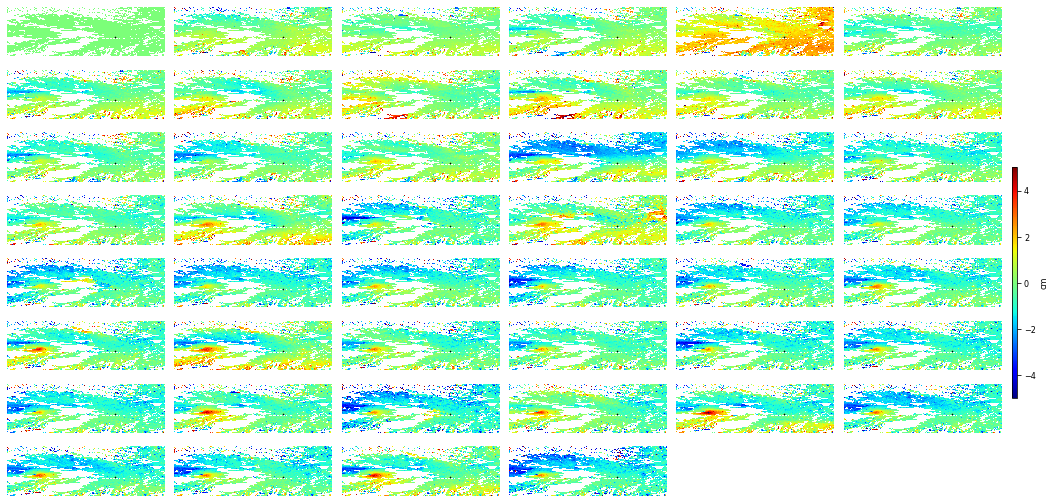

In [28]:
view.main('./minopy/timeseries.h5 --wrap --wrap-range -5 5 -u cm --notitle --notick --noaxis'.split())

### 2.8 MintPy Corrections (time series analysis) ###

This step would apply different timeseries corrections from MintPy. Since the outputs are in the same format as MintPy, you can switch on any of the correction methods. In fact you can use smallbaselineApp.py instead and run the steps after `correct_LOD`. 

Run `smallbaselineApp.py -h` for more help on the correction steps.

For this example we would only correct for topographic phase residuals and all others are set to `no` in the template file.

In [29]:
!minopyApp.py PichinchaSenDT142.template --dostep mintpy_corrections --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-09-14
--RUN-at-2021-09-14 15:07:51.773942--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['mintpy_corrections']
Remaining steps: []
Project name: PichinchaSenDT142
--------------------------------------------------
20210914:150751 * minopyApp.py PichinchaSenDT142.template --dostep mintpy_corrections --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /User

read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with ZERO temporal coherence
skip pixels with NaN  in ANY acquisit

close HDF5 file /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries_demErr.h5.
update "REF_DATE" attribute value to 20170408
time used: 00 mins 3.3 secs.


******************** step - velocity ********************

timeseries2velocity.py /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries_demErr.h5 -t /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg -o /Users/Sara/data/test/PichinchaSenDT142/minopy/velocity.h5 --update
read options from template file: smallbaselineApp.cfg
open timeseries file: timeseries_demErr.h5
exclude date:['20160606', '20170315']
--------------------------------------------------
dates from input file: 46
['20160419', '20160501', '20160513', '20160525', '20160606', '20160630', '20160724', '20160805', '20160817', '20160829', '20160910', '20160922', '20161016', '20161022', '20161109', '20161115', '20161209', '20170102', '20170126', '20170219', '20170303', '20170315', '20170327', '20170408', '20170420', '20170502', '20170514', '20170526

nearest resampling with pyresample.kd_tree using 1 CPU cores in 2 segments ...
write data in block [0, 530, 0, 1685] to file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_geometryRadar.h5
--------------------------------------------------
resampling file: temporalCoherence.h5
update mode: ON
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: temporalCoherence.h5
create HDF5 file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_temporalCoherence.h5 with w mode
create dataset  : temporalCoherence of float32                   in size of (530, 1685)          with compression = None
close  HDF5 file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_temporalCoherence.h5
--------------------------------------------------
reading temporalCoherence in block (0, 0, 1684, 529) from temporalCoherence.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 2 segments ...
write data in block [0, 530, 0

view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 timeseries_demErr.h5 --noaxis -u cm --wrap --wrap-range -5 5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 geo/geo_maskTempCoh.h5 -c gray
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 geo/geo_temporalCoherence.h5 -c gray
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 geo/geo_avgSpatialCoh.h5 -c gray
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 geo/geo_velocity.h5 velocity
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 geo/geo_timeseries_demErr.h5 --noaxis -u cm --wrap --wrap-range -5 5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 numInvIfgram.h5 --mask no
copy *.txt files into ./pic directory.
move *.png/pdf/kmz files to ./pic directory.
time used: 00 mins 21.4 secs.
Explore more info & visualization options with the following scripts:
        info.py                    #check HDF5 file structure and metadata
       

view.py ./minopy/temporalCoherence.h5 -c gray --notick --noaxis --noverbose


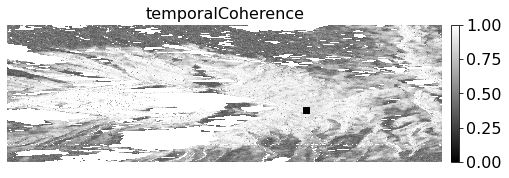

view.py ./minopy/maskTempCoh.h5 -c gray --notick --noaxis --noverbose


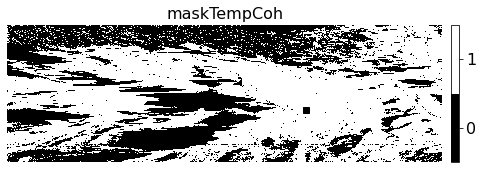

In [30]:
view.main('./minopy/temporalCoherence.h5 -c gray --notick --noaxis --noverbose'.split())
view.main('./minopy/maskTempCoh.h5 -c gray --notick --noaxis --noverbose'.split())

run view.py in MintPy release version v1.3.1-9, release date 2021-08-14
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries_demErr.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries_demErr.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 'timeserie

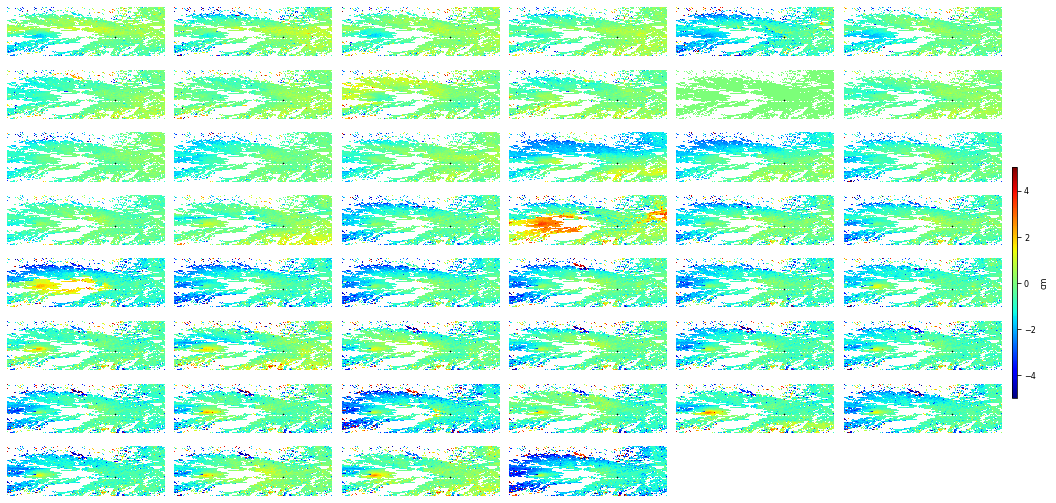

In [26]:
view.main('./minopy/timeseries_demErr.h5 --wrap --wrap-range -5 5 --notitle --notick --noaxis'.split())

***View with PS mask:***

view.py ./minopy/velocity.h5 velocity -m ./minopy/maskPS.h5 --notick --noaxis --noverbose


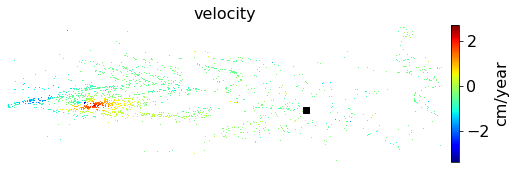

In [38]:
view.main('./minopy/velocity.h5 velocity -m ./minopy/maskPS.h5 --notick --noaxis --noverbose'.split())

***View PS and DS:***

view.py ./minopy/velocity.h5 velocity -m ./minopy/maskTempCoh.h5 --notick --noaxis --noverbose


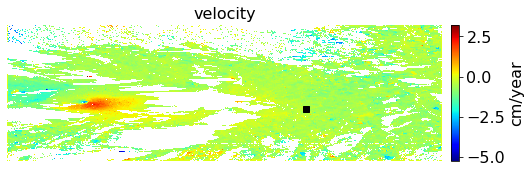

In [40]:
view.main('./minopy/velocity.h5 velocity -m ./minopy/maskTempCoh.h5 --notick --noaxis --noverbose'.split())

In [61]:
!ls -l ./minopy/geo

total 440344
-rw-rw-r--  1 Sara  staff    3704104 Aug 14 11:05 geo_avgSpatialCoh.h5
-rw-rw-r--  1 Sara  staff   23031392 Aug 14 11:05 geo_geometryRadar.h5
-rw-rw-r--  1 Sara  staff     929096 Aug 14 11:20 geo_maskTempCoh.h5
-rw-rw-r--  1 Sara  staff    3705288 Aug 14 11:20 geo_temporalCoherence.h5
-rw-rw-r--  1 Sara  staff  176531720 Aug 14 11:20 geo_timeseries_demErr.h5
-rw-rw-r--  1 Sara  staff    7390072 Aug 14 11:20 geo_velocity.h5


view.py ./minopy/geo/geo_velocity.h5 velocity --dem ./minopy/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose


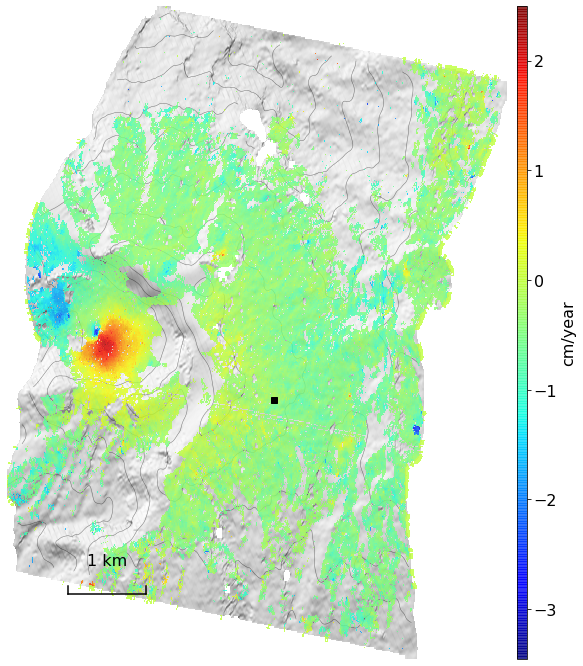

In [4]:
view.main('./minopy/geo/geo_velocity.h5 velocity --dem ./minopy/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose'.split())


## 3. Correct for geolocation ##

Working in full resolution, required preceise geolocation specially in urban areas. 
This is a separate post processing step you may want to perform.

After topographic residual correction step of MintPy, There is `demErr.h5` as a by-product. You can use it as bellow to correct the geo coordinates stored in `./minopy/inputs/geometryRadar.h5`. 

```
correct_geolocation.py -g ./minopy/inputs/geometryRadar.h5 -d ./minopy/demErr.h5
```

**Remember: This correction is in radar coordinate and you need to run it before geocode step in MintPy, or run the geocoding again:**

```
smallbaselineApp.py PichinchaSenDT142.template --dir ./minopy --start geocode
```